# 用于手写数字识别的神经网络，二进制

在本练习中，您将使用神经网络来识别手写数字0和1。

# 大纲

- [1 包]()
- [2 神经网络]()
   - [2.1 问题陈述]()
   - [2.2 数据集]()
   - [2.3 模型表示]()
   - [2.4 Tensorflow 模型实现]()
     - [练习1]()
   - [2.5 NumPy模型实现（NumPy中的Forward Prop）]()
     - [练习2]()
   - [2.6 矢量化NumPy模型实现（可选）]()
     - [练习3]()
   - [2.7 恭喜！]()
   - [2.8 NumPy广播教程（可选）]()

## 1 套餐

首先，让我们运行下面的单元来导入您在此作业期间需要的所有包。

- [numpy](https://numpy.org/)是使用Python进行科学计算的基础包。
- [matplotlib](https://matplotlib.org)是一个流行的Python绘图库。
- [tensorflow](https://www.tensorflow.org/)一个流行的机器学习平台。

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config, )

**TensorFlow和Keras**

Tensorflow是Google开发的机器学习包。2019年，谷歌将Keras集成到Tensorflow中，并发布了Tensorflow 2.0。Keras是François Chollet独立开发的框架，它创建了一个简单的、以层为中心的Tensorflow接口。本课程将使用Keras界面。

## 2 神经网络

在课程1中，您实现了逻辑回归。这被扩展为使用多项式回归处理非线性边界。对于图像识别等更复杂的场景，神经网络是首选。

### 2.1 问题陈述

在本练习中，您将使用神经网络来识别两个手写数字：零和一。这是一个二元分类任务。自动手写数字识别如今已得到广泛应用——从识别邮件信封上的邮政编码（邮政编码）到识别银行支票上的金额。您将扩展此网络，以便在将来的作业中识别所有10个数字（0-9）。

本练习将向您展示如何将您学到的方法用于此分类任务。

### 2.2 数据集

您将首先加载此任务的数据集。

- 下面显示的`load_data()`函数将数据加载到变量`X`和`y`中
- 数据集包含1000个手写数字$^1$的训练示例，这里限制为0和1。
    - 每个训练示例都是数字的20像素x20像素灰度图像。
        - 每个像素都由浮点数表示，指示该位置的灰度强度。
        - 20x20像素网格“展开”为400维向量。
        - 每个训练示例都成为数据矩阵`X`中的一行。
        - 这为我们提供了一个1000x400矩阵`X`，其中每一行都是手写数字图像的训练示例。

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- 训练集的第二部分是一个1000x1维向量`y`，其中包含训练集的标签
    - 如果图像是数字`0`，则`y = 0`；如果图像是数字`1`，则`y = 1`。

$^1$<sub>这是MNIST手写数字数据集的子集 (https://yann.lecun.com/exdb/mnist/)</sub>

In [2]:
X, y = load_data()

#### 2.2.1 查看变量

让我们更熟悉您的数据集。

- 一个好的起点是打印出每个变量并查看它包含的内容。

下面的代码打印变量`X`和`y`的元素。

In [3]:
print('The first element of X is: ', X[0])

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [4]:
print('The first element of y is: ', y[0, 0])
print('The last element of y is: ', y[-1, 0])

The first element of y is:  0
The last element of y is:  1


#### 2.2.2 检查变量的维度

熟悉数据的另一种方法是查看其维度。请打印`X`和`y`的形状，并查看数据集中有多少个训练示例。

In [5]:
print('The shape of X is: ' + str(X.shape))
print('The shape of y is: ' + str(y.shape))

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


#### 2.2.3 可视化数据

您将首先可视化训练集的子集。

- 在下面的单元格中，代码从`X`中随机选择64行，将每行映射回20像素x20像素的灰度图像，并将图像一起显示。
- 每个图像的标签显示在图像上方

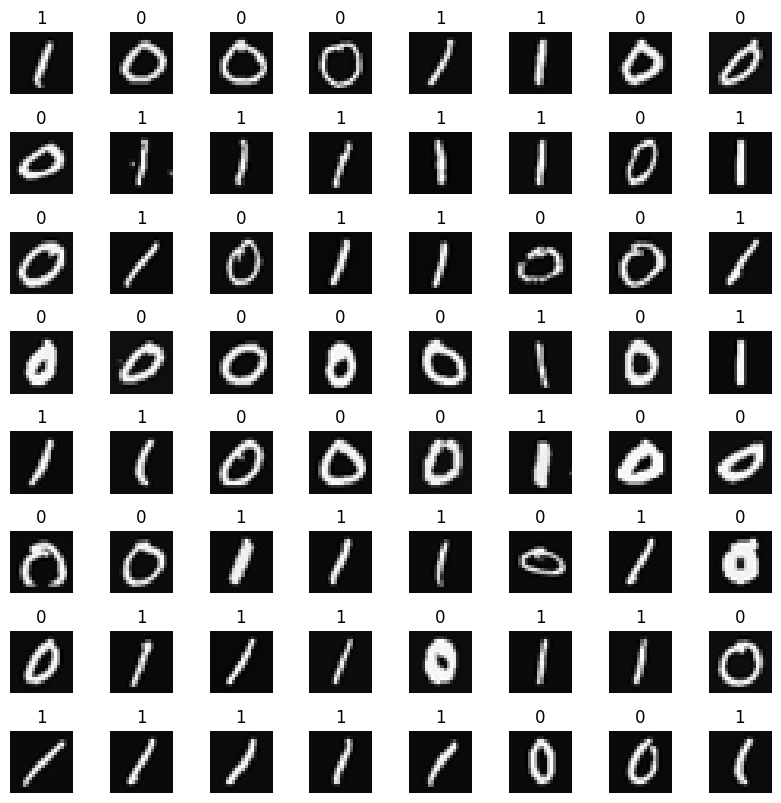

In [6]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1)
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_title(y[random_index, 0])
    ax.set_axis_off()

### 2.3 模型表示

您将在本次作业中使用的神经网络如下图所示。

- 它具有三个带有sigmoid激活的密集层。
    - 回想一下，我们的输入是数字图像的像素值。
    - 由于图像大小为$20\times20$，这为我们提供了$400$输入
    
<img src="../../images/C2_W1_Assign1.PNG" width="500" height="400">

- 参数的尺寸适合神经网络，第1层为$25$单位，第2层为$15$单位，第3层为$1$输出单位。
    - 回想一下，这些参数的维度确定如下：
        - 如果网络在一层中有$s_{in}$单元，在下一层有$s_{out}$单元，则
            - $W$的尺寸为$s_{in}\times s_{out}$。
            - $b$将是一个带有$s_{out}$元素的向量
    - 因此，`W`和`b`的形状是
        - 第1层：`W1`的形状为`(400, 25)`，`b1`的形状为`(25,)`
        - 第2层：`W2`的形状是`(25, 15)`，`b2`的形状是：`(15,)`
        - 第3层：`W3`的形状是`(15, 1)`，`b3`的形状是：`(1,)`

>**注意：** 偏差向量b可以表示为一维`(n,)`或二维`(n,1)`数组。Tensorflow使用一维表示，本实验室将维持该约定。

### 2.4 Tensorflow模型实现

Tensorflow模型是逐层构建的。图层的输入尺寸（上面的$s_{in}$）是为您计算的。您指定图层的*输出尺寸*，这决定了下一层的输入尺寸。第一层的输入维度源自下面`model.fit`语句中指定的输入数据的大小。

>**注意：** 还可以添加一个输入层，指定第一层的输入维度。例如：`tf.keras.Input(shape=(400,)), #指定输入形状`我们将在这里添加它来说明一些模型尺寸。

### 练习1

下面，使用Keras[顺序模型](https://keras.io/guides/sequential_model/)和[密集层](https://keras.io/api/layers/core_layers/dense/)以及sigmoid激活构建上述网络。

In [7]:
model = Sequential(
    [tf.keras.Input(shape=(400,)), Dense(units=25, activation='sigmoid'), Dense(units=15, activation='sigmoid'),
     Dense(units=1, activation='sigmoid')], name="my_model")

In [8]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                10025     
                                                                 
 dense_1 (Dense)             (None, 15)                390       
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


In [9]:
from public_tests import *

test_c1(model)

All tests passed!


摘要中显示的参数计数对应于权重和偏差数组中的元素数量，如下所示。

In [10]:
L1_num_params = 400 * 25 + 25
L2_num_params = 25 * 15 + 15
L3_num_params = 15 * 1 + 1
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params)

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


让我们进一步检查权重，以验证张量流产生的尺寸与我们上面计算的尺寸相同。

In [11]:
[layer1, layer2, layer3] = model.layers

In [12]:
W1, b1 = layer1.get_weights()
W2, b2 = layer2.get_weights()
W3, b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


**期望输出**

```
W1 shape = (400, 25), b1 shape = (25,)  
W2 shape = (25, 15), b2 shape = (15,)  
W3 shape = (15, 1), b3 shape = (1,)
```

`xx.get_weights`返回一个NumPy数组。人们还可以直接以张量形式访问权重。注意最后一层张量的形状。

In [13]:
print(model.layers[2].weights)

[<tf.Variable 'dense_2/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[ 0.5124813 ],
       [-0.17000937],
       [ 0.4683209 ],
       [ 0.23522186],
       [ 0.46566397],
       [-0.00270015],
       [-0.34098613],
       [ 0.38582754],
       [ 0.0480451 ],
       [ 0.5360401 ],
       [-0.48471022],
       [ 0.08734858],
       [ 0.39090592],
       [-0.130617  ],
       [-0.46745744]], dtype=float32)>, <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


以下代码将定义损失函数并运行梯度下降以使模型的权重适合训练数据。这将在下周进行更详细的解释。

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.001))
model.fit(X, y, epochs=20)

Epoch 1/20
32/32 [==============================] - 3s 1ms/step - loss: 0.6438
Epoch 2/20
32/32 [==============================] - 0s 1ms/step - loss: 0.4965
Epoch 3/20
32/32 [==============================] - 0s 1ms/step - loss: 0.3522
Epoch 4/20
32/32 [==============================] - 0s 1ms/step - loss: 0.2440
Epoch 5/20
32/32 [==============================] - 0s 1ms/step - loss: 0.1760
Epoch 6/20
32/32 [==============================] - 0s 2ms/step - loss: 0.1338
Epoch 7/20
32/32 [==============================] - 0s 1ms/step - loss: 0.1058
Epoch 8/20
32/32 [==============================] - 0s 1ms/step - loss: 0.0865
Epoch 9/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0726
Epoch 10/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0623
Epoch 11/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0543
Epoch 12/20
32/32 [==============================] - 0s 2ms/step - loss: 0.0478
Epoch 13/20
32/32 [==============================

要在示例上运行模型以进行预测，请使用[Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)。`predict`的输入是一个数组，因此单个示例被重塑为二维。

In [15]:
prediction = model.predict(X[0].reshape(1, 400))
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1, 400))
print(f" predicting a one:  {prediction}")

1/1 [==============================] - 0s 41ms/step
 predicting a zero: [[0.0248758]]
1/1 [==============================] - 0s 11ms/step
 predicting a one:  [[0.988483]]


In [16]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


让我们比较64位随机样本的预测与标签。这需要一些时间来运行。

1/1 [==============================] - 0s 13ms/step


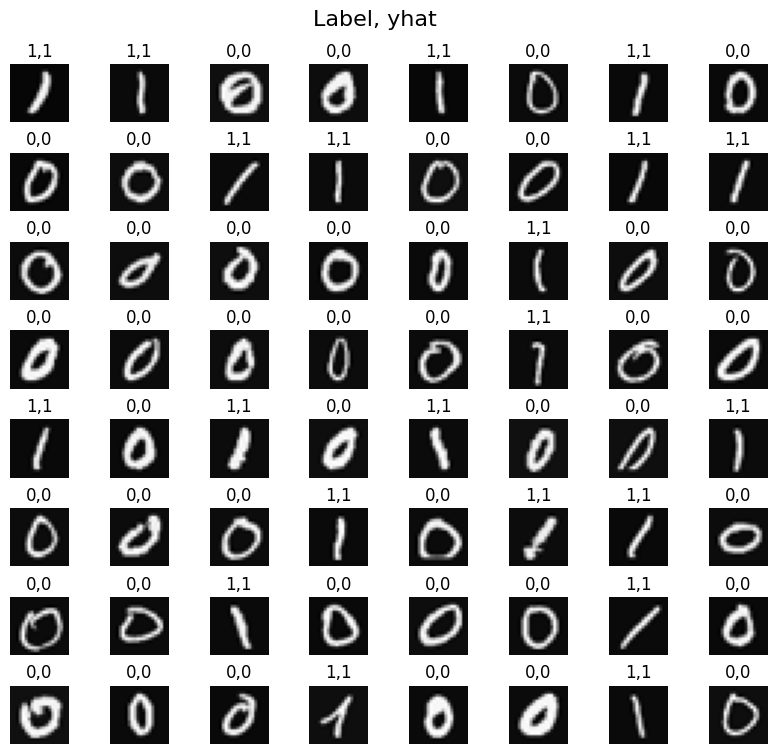

In [17]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    prediction = model.predict(X[random_index].reshape(1, 400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    ax.set_title(f"{y[random_index, 0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

### 2.5 NumPy模型实现（NumPy中的Forward Prop）

正如讲座中所述，可以使用NumPy构建自己的密集层。然后可以利用它来构建多层神经网络。

<img src="../../images/C2_W1_dense2.PNG" width="600" height="450">

### 练习2

下面，构建一个致密层子程序。讲座中的示例使用for循环来访问层中的每个单元（`j`）并执行该单元权重的点积（`W[:,j]`）并对单元的偏差求和（` b[j]`）形成`z`。然后将激活函数`g(z)`应用于该结果。本节将不会使用可选讲座中描述的一些矩阵运算。这些将在后面的部分中探讨。

In [18]:
def my_dense(a_in, W, b, g):
    units = W.shape[1]
    a_out = np.zeros(units)
    for i in range(units):
        a_out[i] = np.dot(a_in, W[:, i]) + b[i]
        a_out[i] = g(a_out[i])
    return a_out

In [19]:
x_tst = 0.1 * np.arange(1, 3, 1).reshape(2, )
W_tst = 0.1 * np.arange(1, 7, 1).reshape(2, 3)
b_tst = 0.1 * np.arange(1, 4, 1).reshape(3, )
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


**期望输出**

```
[0.54735762 0.57932425 0.61063923]
```

In [20]:
test_c2(my_dense)

All tests passed!


以下单元利用上面的`my_dense`子例程构建一个三层神经网络。

In [21]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x, W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return a3

我们可以从Tensorflow复制经过训练的权重和偏差。

In [22]:
W1_tmp, b1_tmp = layer1.get_weights()
W2_tmp, b2_tmp = layer2.get_weights()
W3_tmp, b3_tmp = layer3.get_weights()

In [23]:
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[0, 0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print("yhat = ", yhat, " label= ", y[500, 0])

yhat =  0  label=  0
yhat =  1  label=  1


运行以下单元格以查看Numpy模型和Tensorflow模型的预测。这需要一些时间来运行。

1/1 [==============================] - 0s 11ms/step


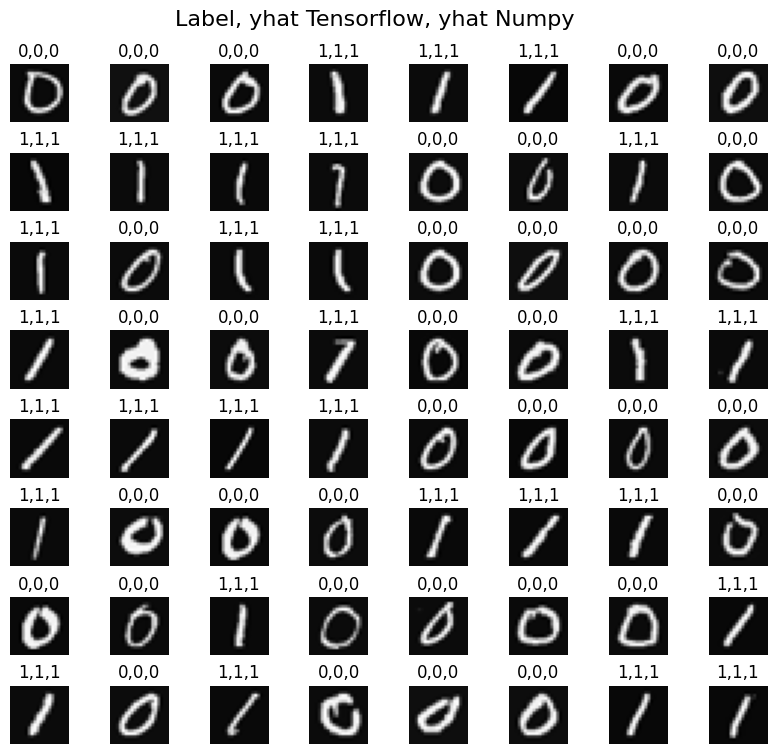

In [24]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
    my_yhat = int(my_prediction[0] >= 0.5)
    tf_prediction = model.predict(X[random_index].reshape(1, 400))
    tf_yhat = int(tf_prediction[0][0] >= 0.5)
    ax.set_title(f"{y[random_index, 0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

### 2.6 向量化NumPy模型实现（可选）

可选讲座描述了可用于加速计算的向量和矩阵运算。

下面描述了一个层操作，该操作在给定的输入示例上计算层中所有单元的输出：

<img src="../../images/C2_W1_VectorMatrix.PNG" width="600" height="450">

我们可以使用上面的示例`X`和`W1`、`b1`参数来演示这一点。我们使用`np.matmul`来执行矩阵乘法。请注意，`x`和`W`的尺寸必须兼容，如上图所示。

In [25]:
x = X[0].reshape(-1, 1)
z1 = np.matmul(x.T, W1) + b1
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


您可以更进一步，在一次矩阵-矩阵运算中计算所有示例的所有单位。

<img src="../../images/C2_W1_MatrixMatrix.PNG" width="600" height="450">

完整的运算是$\mathbf{Z}=\mathbf{XW}+\mathbf{b}$。这将利用NumPy广播将$\mathbf{b}$扩展到$m$行。如果这不熟悉，笔记本末尾提供了一个简短的教程。

### 练习3

下面，编写一个新的`my_dense_v`子例程，该子例程对示例矩阵执行层计算。这将利用`np.matmul()`。

In [26]:
def my_dense_v(A_in, W, b, g):
    A_out = np.matmul(A_in, W) + b
    A_out = g(A_out)
    return A_out

In [27]:
X_tst = 0.1 * np.arange(1, 9, 1).reshape(4, 2)
W_tst = 0.1 * np.arange(1, 7, 1).reshape(2, 3)
b_tst = 0.1 * np.arange(1, 4, 1).reshape(1, 3)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid)
print(A_tst)

tf.Tensor(
[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]], shape=(4, 3), dtype=float64)


**期望输出**

```
[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]
 ```

In [28]:
test_c3(my_dense_v)

All tests passed!


以下单元利用上面的`my_dense_v`子例程构建一个三层神经网络。

In [30]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X, W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return A3

我们可以再次从Tensorflow复制经过训练的权重和偏差。

In [31]:
W1_tmp, b1_tmp = layer1.get_weights()
W2_tmp, b2_tmp = layer2.get_weights()
W3_tmp, b3_tmp = layer3.get_weights()

让我们用新模型进行预测。这将同时对*所有示例*进行预测。注意输出的形状。

In [32]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp)
Prediction.shape

TensorShape([1000, 1])

我们将像以前一样应用0.5的阈值，但同时应用于所有预测。

In [33]:
Yhat = (Prediction >= 0.5).numpy().astype(int)
print("predict a zero: ", Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


运行以下单元格以查看预测。这将使用我们上面刚刚计算的预测。这需要一些时间来运行。

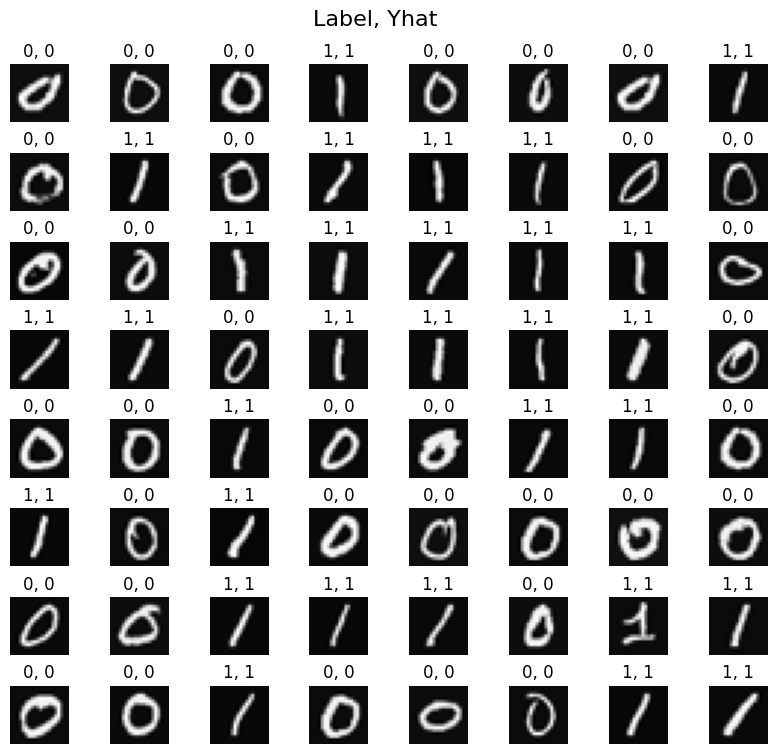

In [34]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
m, n = X.shape
fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92])
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(m)
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    ax.imshow(X_random_reshaped, cmap='gray')
    ax.set_title(f"{y[random_index, 0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off()
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

您可以看到其中一张错误分类的图像的外观。

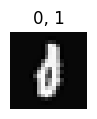

In [35]:
fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index, 0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()

### 2.7 恭喜！

您已经成功构建并使用了神经网络。

### 2.8 NumPy广播教程（可选）

在最后一个例子中，$\mathbf{Z}=\mathbf{XW}+\mathbf{b}$利用NumPy广播来扩展向量$\mathbf{b}$。如果您不熟悉NumPy广播，可以阅读此简短教程。

$\mathbf{XW}$是维度为$(m,j_1)(j_1,j_2)$的矩阵-矩阵运算，生成维度为$(m,j_2)$的矩阵。为此，我们添加一个维度为$(j_2,)$的向量$\mathbf{b}$。$\mathbf{b}$必须扩展为$(m,j_2)$矩阵，此逐元素运算才有意义。此扩展是通过NumPy广播为您完成的。

广播适用于逐元素操作。

其基本操作是通过复制元素来“拉伸”较小的维度以匹配较大的维度。

更多[具体](https://NumPy.org/doc/stable/user/basics.broadcasting.html)：

当操作两个数组时，NumPy按元素比较它们的形状。它从尾随（即最右边）尺寸开始并向左移动。两个维度兼容时

- 它们是相等的，或者
- 其中之一是1

如果不满足这些条件，则会抛出ValueError: operands Could not be Broadcast Together异常，表明数组的形状不兼容。结果数组的大小是沿输入的每个轴不为1的大小。

这里有些例子：

<figure>
    <center>
        <img src="../../images/C2_W1_Assign1_BroadcastIndexes.png" alt='missing' width="400">
    <center/>
    <figcaption>
        计算广播结果形状
    </figcaption>
<figure/>

下图描述了扩展尺寸。注意下面红色文字：

<figure>
    <center>
        <img src="../../images/C2_W1_Assign1_Broadcasting.gif" alt='missing' width="600">
    <center/>
    <figcaption>
        广播理论上扩展了参数以匹配元素明智的操作
    </figcaption>
<figure/>

上图显示NumPy在最终操作之前扩展参数以进行匹配。请注意，这是一个概念性的描述。NumPy操作的实际机制选择最有效的实现。

对于以下每个示例，请在运行示例之前尝试猜测结果的大小。

In [36]:
a = np.array([1, 2, 3]).reshape(-1, 1)
b = 5
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

(a + b).shape: (3, 1), 
a + b = 
[[6]
 [7]
 [8]]


请注意，这适用于所有逐元素操作：

In [37]:
a = np.array([1, 2, 3]).reshape(-1, 1)
b = 5
print(f"(a * b).shape: {(a * b).shape}, \na * b = \n{a * b}")

(a * b).shape: (3, 1), 
a * b = 
[[ 5]
 [10]
 [15]]


<figure>
    <img src="../../images/C2_W1_Assign1_VectorAdd.PNG" alt='missing' width="740" >
    <center>
        <figcaption>
            <b>
                行列逐元素运算
            </b>
        </figcaption>
    </center>
<figure/>

In [38]:
a = np.array([1, 2, 3, 4]).reshape(-1, 1)
b = np.array([1, 2, 3]).reshape(1, -1)
print(a)
print(b)
print(f"(a + b).shape: {(a + b).shape}, \na + b = \n{a + b}")

[[1]
 [2]
 [3]
 [4]]
[[1 2 3]]
(a + b).shape: (4, 3), 
a + b = 
[[2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]]


这是您上面构建的密集层中的场景。将一维向量$b$添加到`(m,j)`矩阵。

<figure>
    <img src="../../images/C2_W1_Assign1_BroadcastMatrix.png" alt='missing' width="740">
    <center>
        <figcaption>
            <b>
                矩阵加一维向量
            </b>
        </figcaption>
    </center>
<figure/>